In [1]:
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import tempfile
import os
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/01_Preprocessing')

In [2]:
print(sc.__version__)

1.10.4


In [2]:
metadata = pd.read_csv("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/01_Preprocessing/meta_of_interest.txt", sep = "\t")

In [3]:
metadata

,geo_accession,gender,cancer_type,cell_population,barcodes_file,matrix_file,features_file
0,GSM4909281,Female,TNBC,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
1,GSM4909282,Female,TNBC,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
2,GSM4909283,Female,TNBC,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
3,GSM4909284,Female,TNBC,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
4,GSM4909285,Female,TNBC_BRCA,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
5,GSM4909286,Female,TNBC_BRCA,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
6,GSM4909287,Female,TNBC_BRCA,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
7,GSM4909288,Female,TNBC_BRCA,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
8,GSM4909289,Female,HER2,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...
9,GSM4909290,Female,HER2,Total,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4909...,https://ftp.ncbi.nlm.nih.gov/geo/series/GSE161...


In [4]:
import os
import tempfile
import subprocess
import hashlib
import scanpy as sc

adata_dict = {}

for index, row in metadata.iterrows():
    ftp_files = []
    
    ftp_files.append(row.barcodes_file)
    ftp_files.append(row.matrix_file)
    ftp_files.append(row.features_file)

    sample_name = row.geo_accession


    with tempfile.TemporaryDirectory() as tmpdir:
        local_paths = []
        
        for url in ftp_files:
            elem = os.path.basename(url)
            
            if 'matrix.mtx.gz' in elem:
                filename = 'matrix.mtx.gz'
            elif 'barcodes.tsv.gz' in elem:
                filename = 'barcodes.tsv.gz'
            elif 'features.tsv.gz' in elem:
                filename = 'features.tsv.gz'
            else:
                raise ValueError(f"Unrecognized 10x file type in {elem}")
            
            local_path = os.path.join(tmpdir, filename)
             
            subprocess.run(["wget", "-q", "-O", local_path, url], check=True)
           
            local_paths.append(local_path)
        
        adata_dict[sample_name] = sc.read_10x_mtx(tmpdir)
        adata_dict[sample_name].obs['batch'] = sample_name

In [5]:
adata_dict

{'GSM4909281': AnnData object with n_obs × n_vars = 3666 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909282': AnnData object with n_obs × n_vars = 15870 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909283': AnnData object with n_obs × n_vars = 1065 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909284': AnnData object with n_obs × n_vars = 2015 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909285': AnnData object with n_obs × n_vars = 5581 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909286': AnnData object with n_obs × n_vars = 6456 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909287': AnnData object with n_obs × n_vars = 9593 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909288': AnnData object with n_obs × n_vars = 21130 × 33538
     obs: 'batch'
     var: 'gene_ids', 'feature_types',
 'GSM4909289': AnnData

In [7]:
with open("unprocessed_adata_dict.pkl", "wb") as f:
    pickle.dump(adata_dict, f)

In [2]:
with open("unprocessed_adata_dict.pkl", "rb") as f:
    adata_dict = pickle.load(f)

In [3]:
for ad in adata_dict.values():
    ad.var['mt'] = ad.var_names.str.match('^MT-')

In [4]:
for ad in adata_dict.values():
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], log1p=True, inplace=True)

In [5]:
adata_dict

{'GSM4909281': AnnData object with n_obs × n_vars = 3666 × 33538
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 'GSM4909282': AnnData object with n_obs × n_vars = 15870 × 33538
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', '

In [6]:
rows_list = []
for sam, ad in adata_dict.items():
    row_df = pd.DataFrame({"genes_with_pos_counts": ad.obs.n_genes_by_counts, 
                           "counts_per_cell": ad.obs.total_counts, 
                           "pct_counts_mt":ad.obs.pct_counts_mt,
                          "sample": sam})
    rows_list.append(row_df)
df = pd.concat(rows_list, ignore_index=True)

<Axes: title={'center': 'counts_per_cell'}, xlabel='sample'>

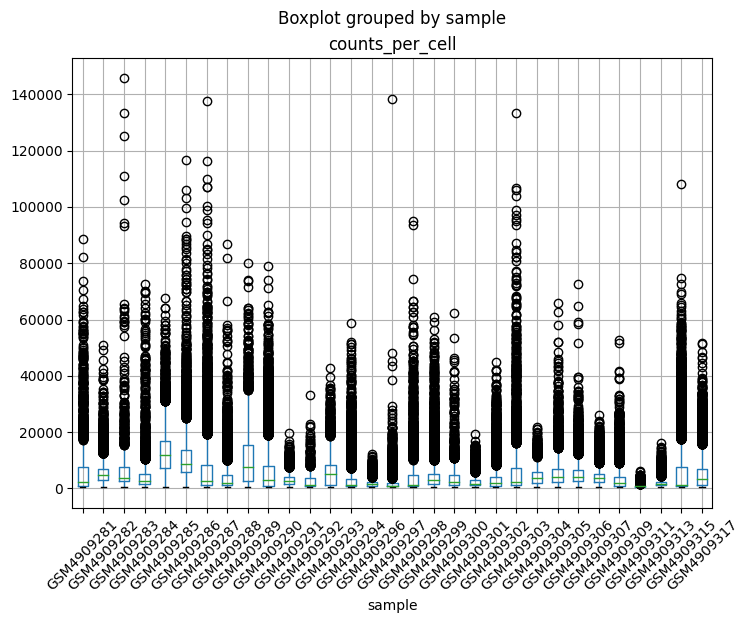

In [7]:
df.boxplot(column="counts_per_cell", by="sample", figsize=(8, 6), rot = 45)

<Axes: title={'center': 'genes_with_pos_counts'}, xlabel='sample'>

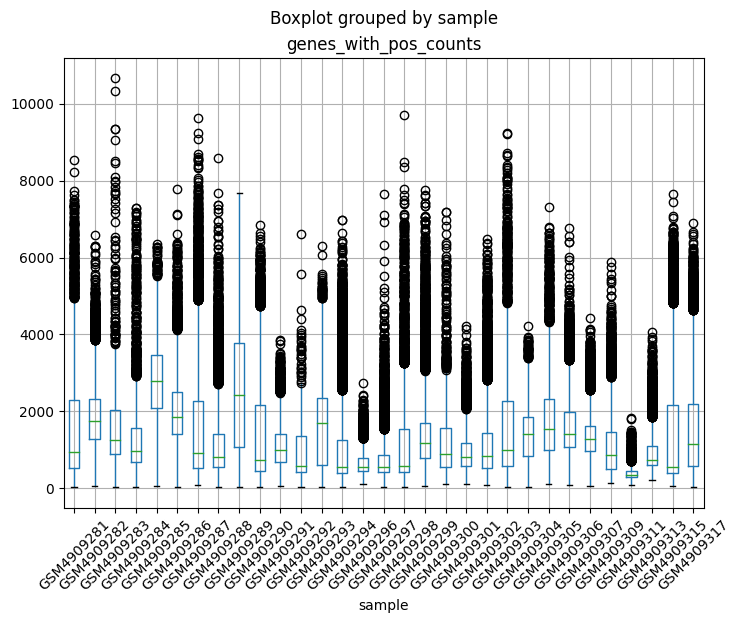

In [8]:
df.boxplot(column="genes_with_pos_counts", by="sample", figsize=(8, 6), rot = 45)

# CELL FILTERING

For the lower tresholds, set a general value, if the 1th percentile is more stringent (higher), use that one. 
if the sample treshold is lower, use the general
if the sample treshold is higher, use the sample specific


For the upper tresholds, set a general value, if the 99th percentile is more stringent (lower), use that one. 
if the sample treshold is higher, use the general
if the sample treshold is lower (more stringent), use the sample specific



In [9]:
for ad in adata_dict.values():

    # GENES LOWER
    genes_lower_treshold = 300
    sample_genes_lower_treshold = np.quantile(ad.obs.n_genes_by_counts,0.01)
    filtering_genes_lower_treshold = max(sample_genes_lower_treshold,genes_lower_treshold)
    sc.pp.filter_cells(ad, min_genes = filtering_genes_lower_treshold, inplace = True)

    # COUNTS LOWER
    counts_lower_treshold = 500
    sample_counts_lower_treshold =np.quantile(ad.obs.total_counts,0.01)
    filtering_counts_lower_treshold = max(sample_counts_lower_treshold, counts_lower_treshold)
    sc.pp.filter_cells(ad, min_counts = filtering_counts_lower_treshold, inplace = True)
    
    # GENES UPPER
    genes_upper_treshold = 6000
    sample_genes_upper_treshold = np.quantile(ad.obs.n_genes_by_counts,0.99)
    filtering_genes_upper_treshold = min(sample_genes_upper_treshold,genes_upper_treshold)
    sc.pp.filter_cells(ad, max_genes = filtering_genes_upper_treshold, inplace = True) 
    # COUNTS UPPER
    counts_upper_treshold = 50000
    sample_counts_upper_treshold = np.quantile(ad.obs.total_counts,0.99)
    filtering_counts_upper_treshold = min(sample_counts_upper_treshold, counts_upper_treshold)
    sc.pp.filter_cells(ad, max_counts = filtering_counts_upper_treshold, inplace = True)

In [10]:
rows_list_post = []
for sam, ad in adata_dict.items():
    row_df_post = pd.DataFrame({"genes_with_pos_counts": ad.obs.n_genes_by_counts, 
                           "counts_per_cell": ad.obs.total_counts, 
                           "pct_counts_mt":ad.obs.pct_counts_mt,
                          "sample": sam})
    rows_list_post.append(row_df_post)
df_post = pd.concat(rows_list_post, ignore_index=True)

<Axes: title={'center': 'counts_per_cell'}, xlabel='sample'>

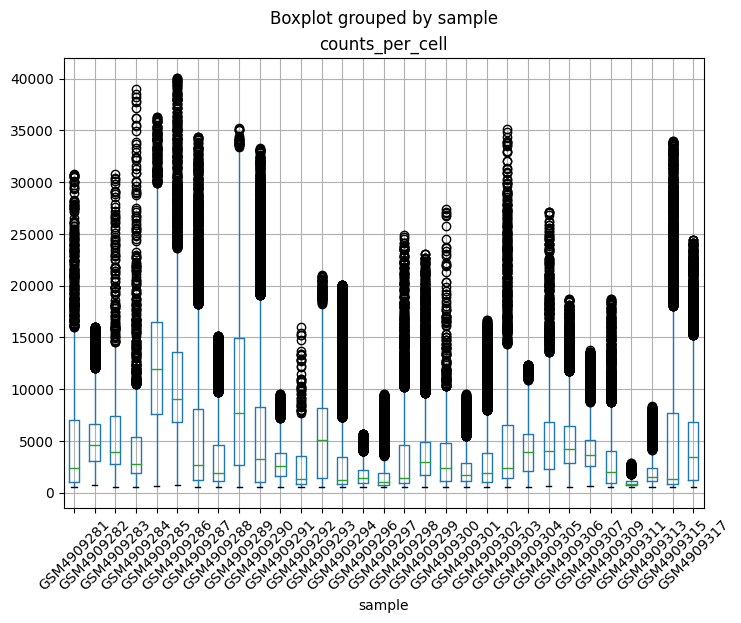

In [11]:
df_post.boxplot(column="counts_per_cell", by="sample", figsize=(8, 6), rot = 45)

<Axes: title={'center': 'genes_with_pos_counts'}, xlabel='sample'>

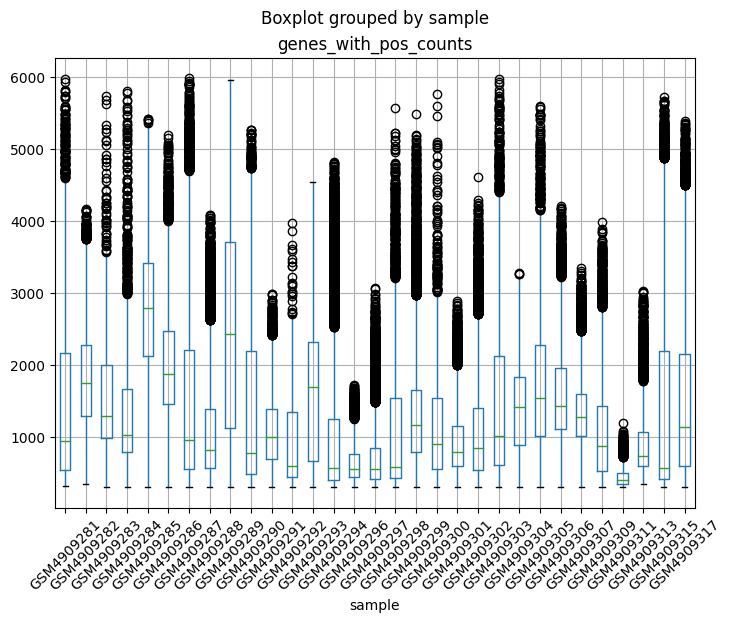

In [12]:
df_post.boxplot(column="genes_with_pos_counts", by="sample", figsize=(8, 6), rot = 45)

# CELL TYPIST ANNOTATION 

CellTypist accepts the input data as a count table (cell-by-gene or gene-by-cell) in the format of .txt, .csv, .tsv, .tab, .mtx or .mtx.gz. A raw count matrix (reads or UMIs) is required. Non-expressed genes (if you are sure of their expression absence in your data) are suggested to be included in the input table as well, as they point to the negative transcriptomic signatures when compared with the model used.

In [60]:
# !pip install celltypist

  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.4 MB/s eta 0:00:009.3 MB/s eta 0:00:01
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)


In [13]:
import celltypist
from celltypist import models

In [14]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/igarzonalva/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_B

In [15]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [16]:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [17]:
import copy
adata_dict_annotation = copy.deepcopy(adata_dict)

In [18]:
for ad in adata_dict_annotation.values():
    sc.pp.normalize_total(ad, target_sum = 10000)
    sc.pp.log1p(ad)    

In [19]:
immune_All_High_prediction_dict = {}


for name, ad in adata_dict_annotation.items():
    immune_All_High_prediction_dict[name] = celltypist.annotate(ad, model = 'Immune_All_High.pkl', 
                                                               majority_voting = True, 
                                                               mode = 'prob match', p_thres = 0.8) # 

    

🔬 Input data has 3436 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 5967 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 15249 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 5967 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 953 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 5967 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct o

In [20]:
rows_list = []
for predictions in immune_All_High_prediction_dict.values():

    rows_list.append(predictions.probability_matrix)
    
df = pd.concat(rows_list, ignore_index=True)

<Axes: ylabel='Frequency'>

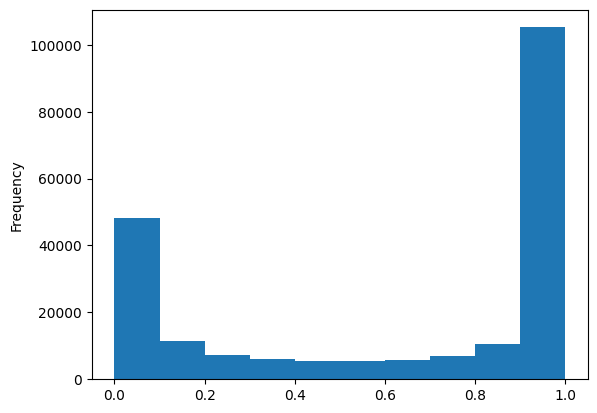

In [21]:
df.max(axis = 1).plot.hist()

In [22]:
for name, ad in adata_dict.items():
    df_predictions = immune_All_High_prediction_dict[name].predicted_labels.reindex(ad.obs_names)
    ad.obs = pd.concat([ad.obs, df_predictions], axis=1)

In [23]:
adata_dict

{'GSM4909281': AnnData object with n_obs × n_vars = 3436 × 33538
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 'GSM4909282': AnnData object with n_obs × n_vars = 15249 × 33538
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'ov

# Filter non-expressed genes

In [25]:
for ad in adata_dict.values():
    ad.raw = ad.copy() # save all genes before removing any 
    sc.pp.filter_genes(ad, min_counts = 5, inplace=True)
    sc.pp.filter_genes(ad, min_cells = 10, inplace=True)

In [27]:
rows_list_post = []
for sam, ad in adata_dict.items():
    row_df_post = pd.DataFrame({"cells_by_counts": ad.var.n_cells_by_counts, 
                           "counts": ad.var.total_counts, 
                          "sample": sam})
    rows_list_post.append(row_df_post)
df_post = pd.concat(rows_list_post, ignore_index=True)

<Axes: title={'center': 'cells_by_counts'}, xlabel='sample'>

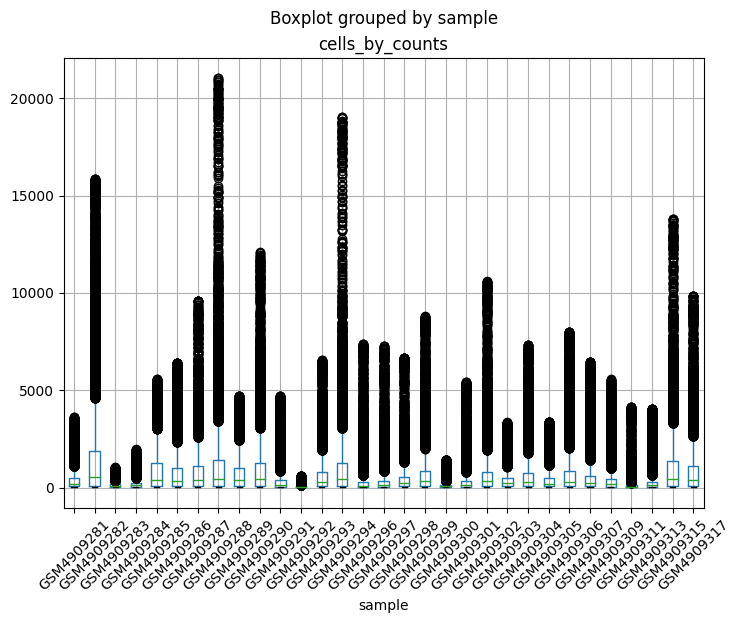

In [28]:
df_post.boxplot(column="cells_by_counts", by="sample", figsize=(8, 6), rot = 45)

<Axes: title={'center': 'counts'}, xlabel='sample'>

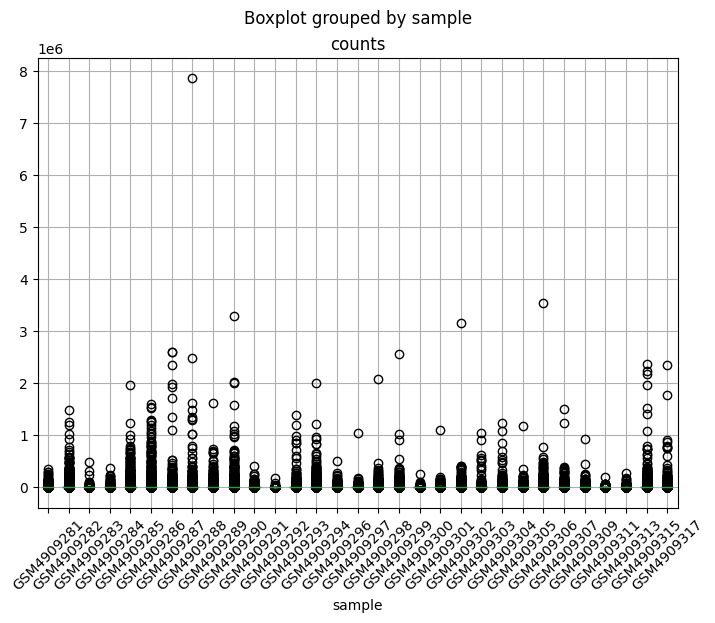

In [29]:
df_post.boxplot(column="counts", by="sample", figsize=(8, 6), rot = 45)

In [40]:
with open("before_scrublet_adata_dict.pkl", "wb") as f:
    pickle.dump(adata_dict, f)

In [3]:
with open("before_scrublet_adata_dict.pkl", "rb") as f:
    adata_dict = pickle.load(f)

# Doublet Removal

Predict cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. Works best if the input is a raw
(unnormalized) counts matrix from a single sample or a collection of similar samples from the same experiment.

src/scanpy/preprocessing/_scrublet/__init__.py

In [5]:
#!pip install scikit-image

  Using cached imageio-2.36.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 8.0 MB/s eta 0:00:000m eta 0:00:010:00:01
Using cached imageio-2.36.1-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)


In [6]:
for ad in adata_dict.values():

    sc.pp.scrublet(ad)

In [8]:
adata_dict

{'GSM4909281': AnnData object with n_obs × n_vars = 3436 × 15927
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'
     uns: 'scrublet',
 'GSM4909282': AnnData object with n_obs × n_vars = 15249 × 17467
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p

https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb \
The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.

To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. scrub_doublets() attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the call_doublets() function. For example:

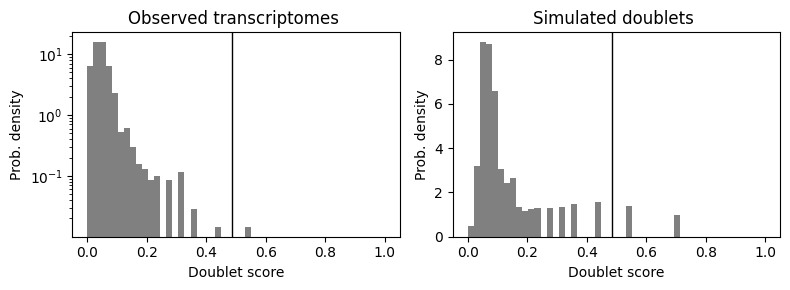

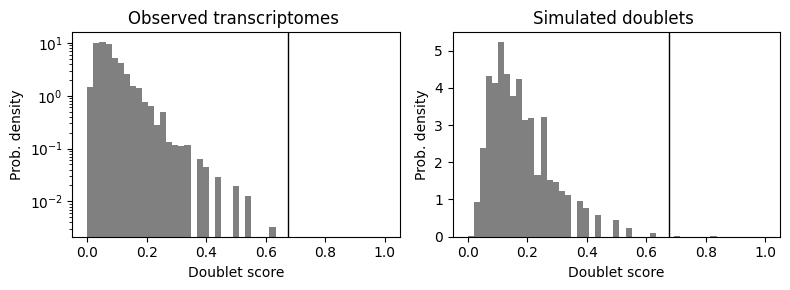

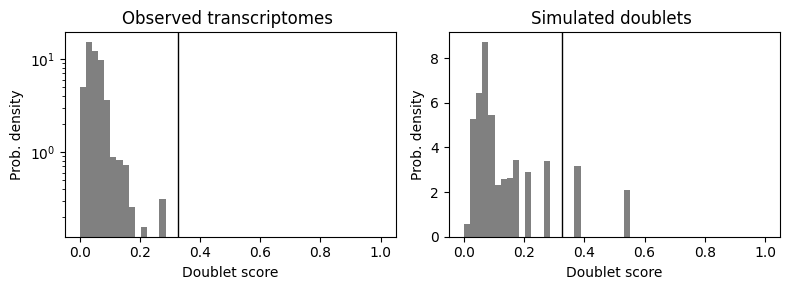

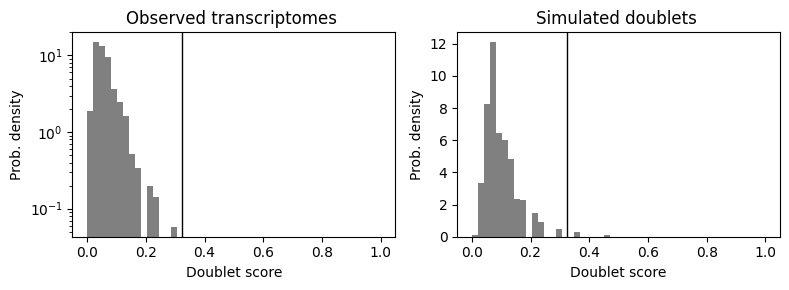

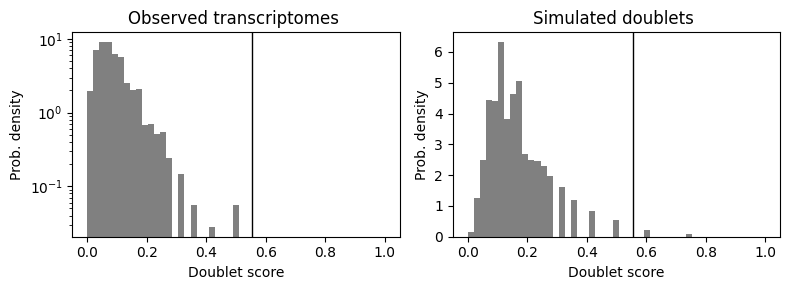

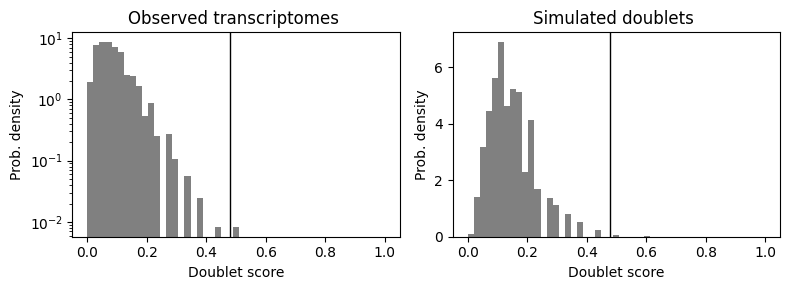

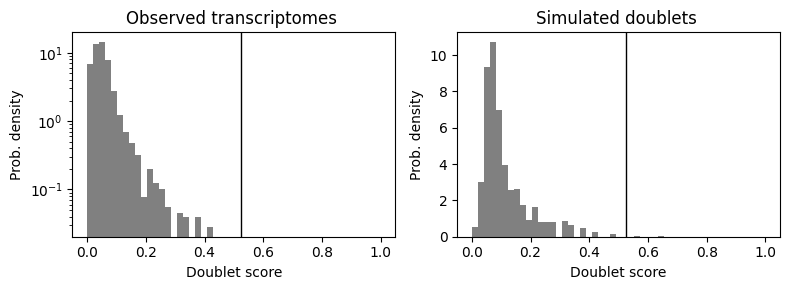

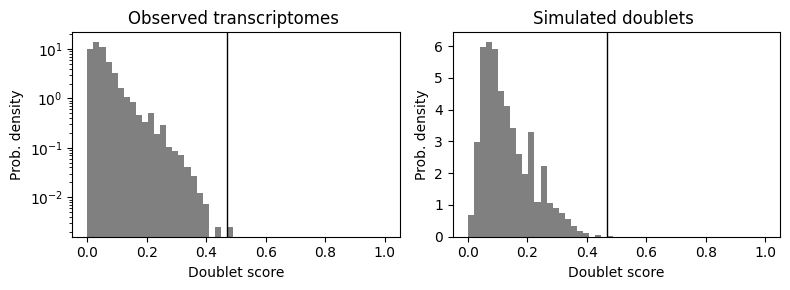

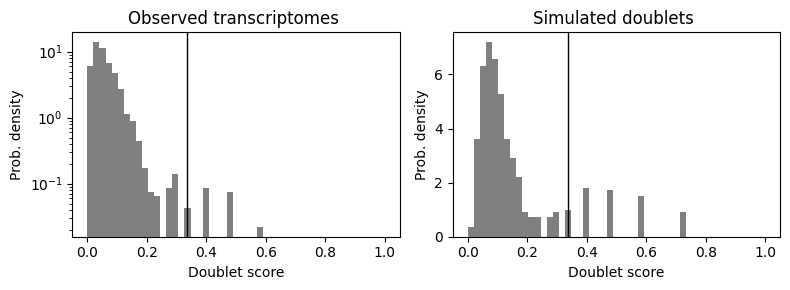

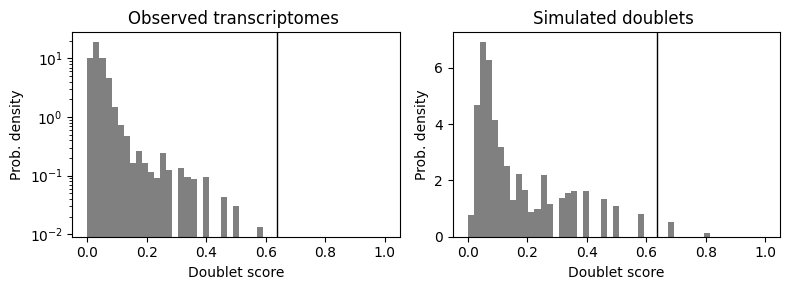

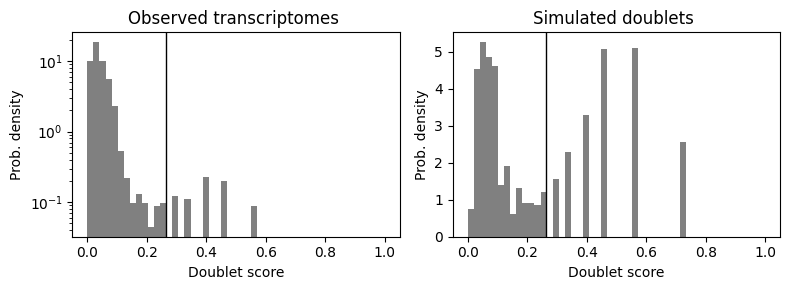

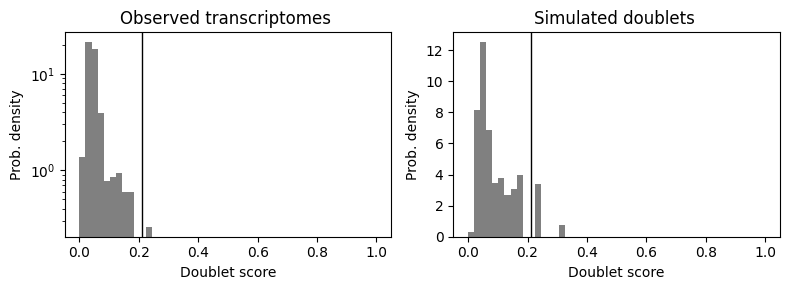

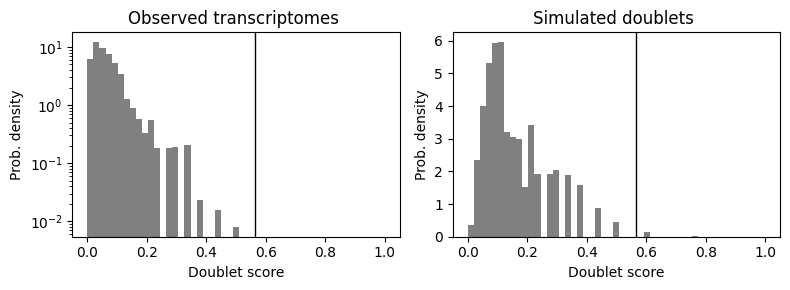

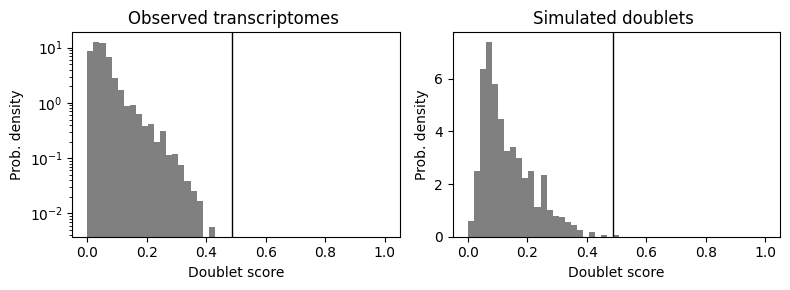

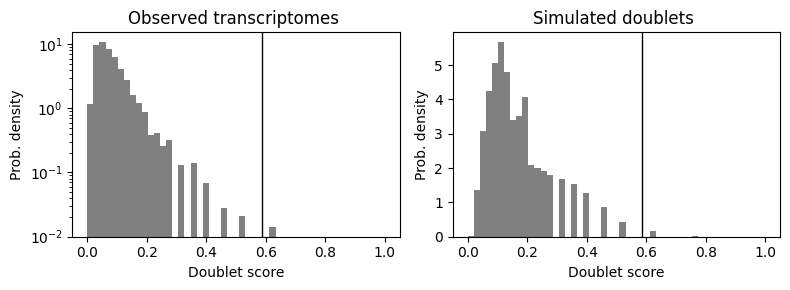

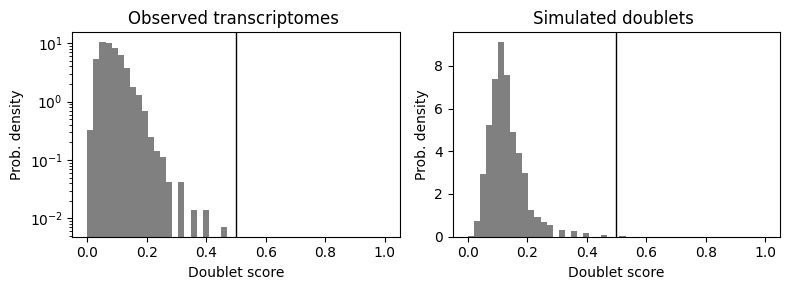

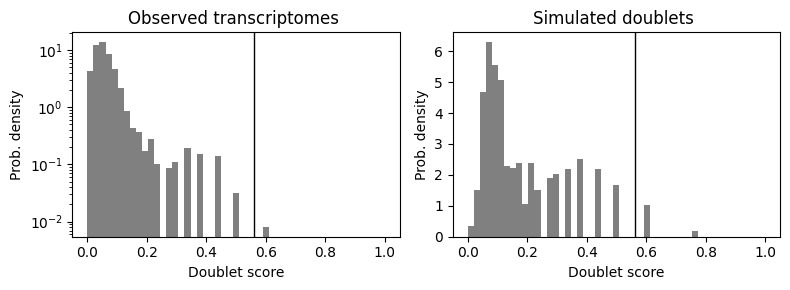

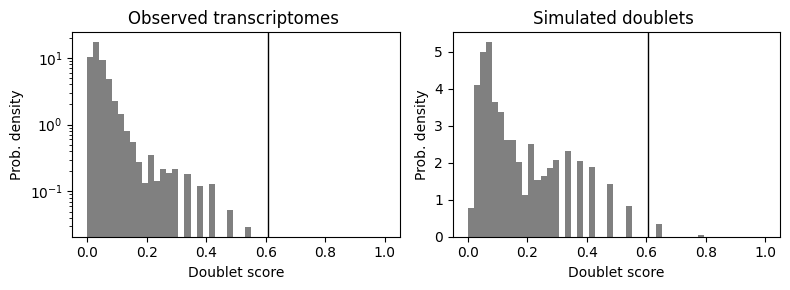

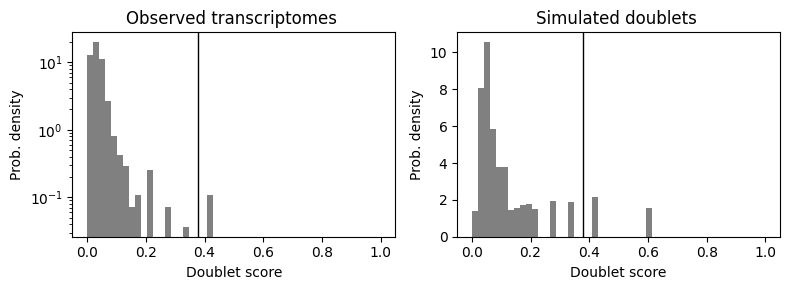

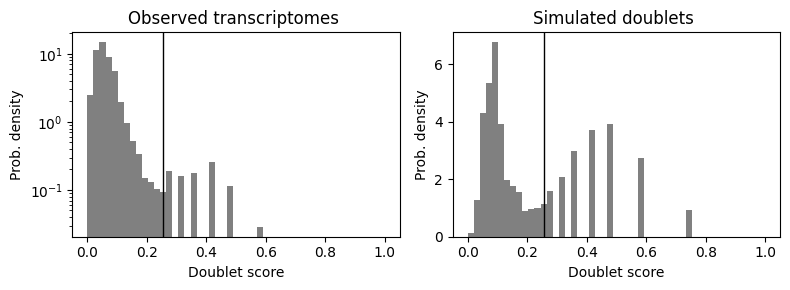

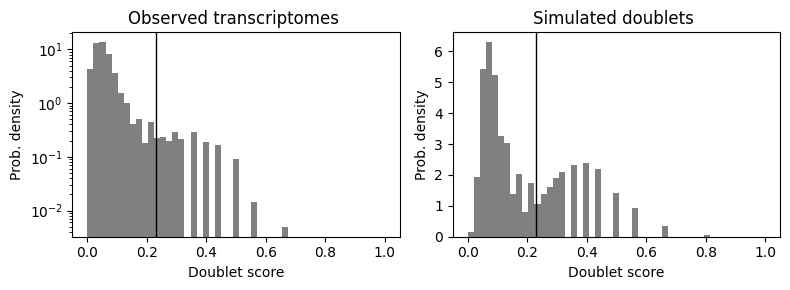

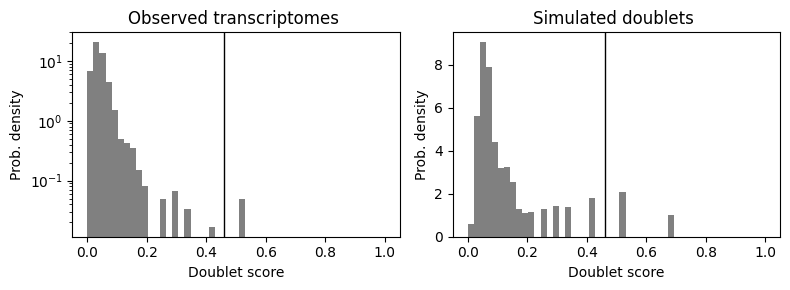

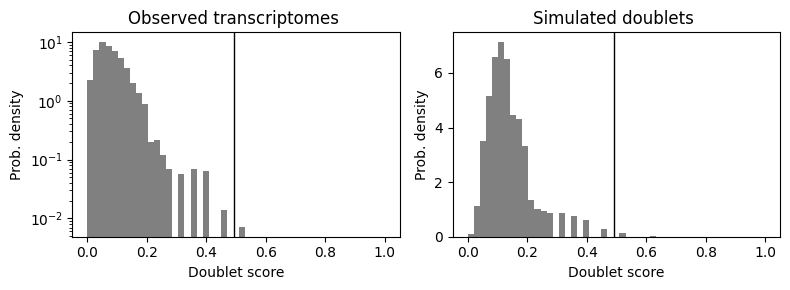

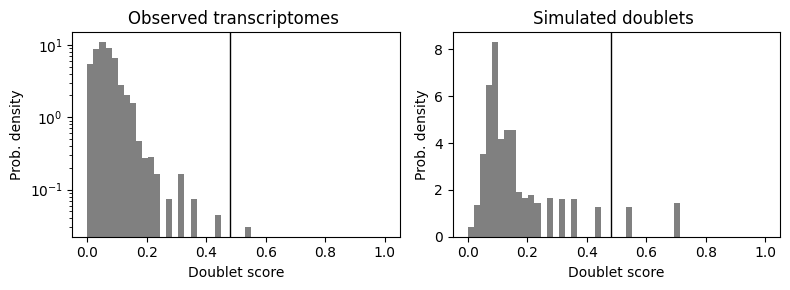

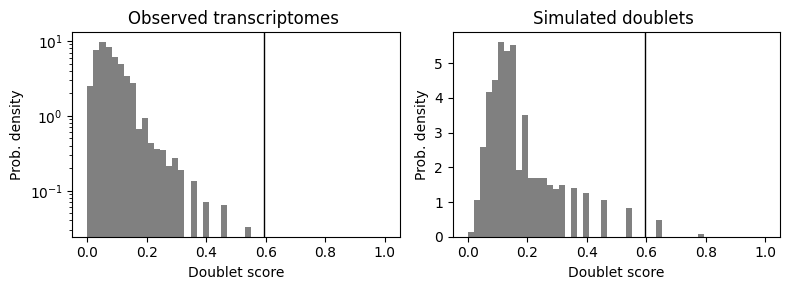

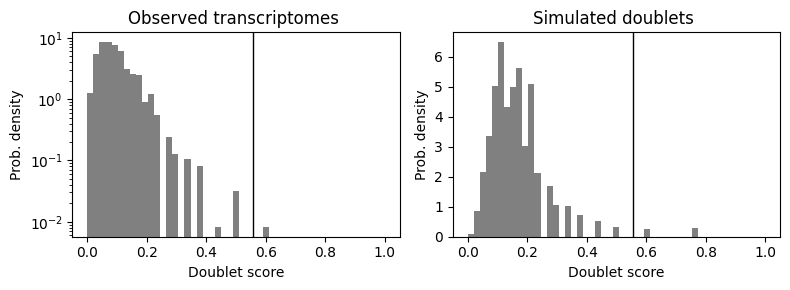

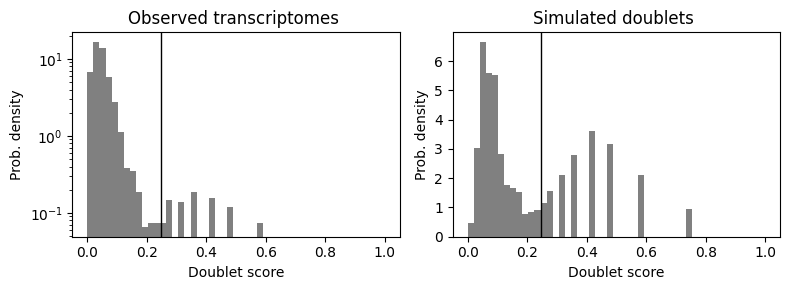

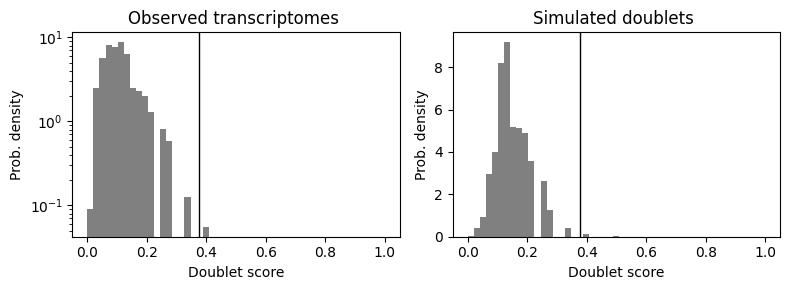

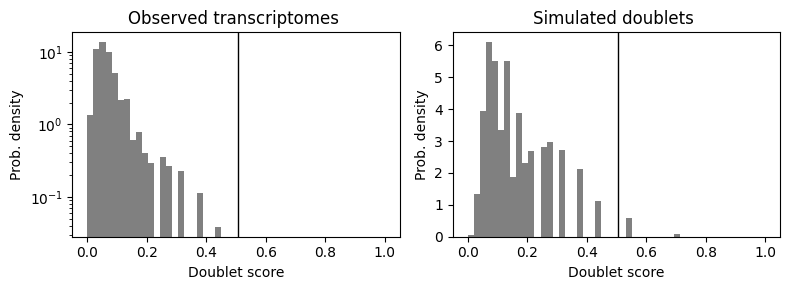

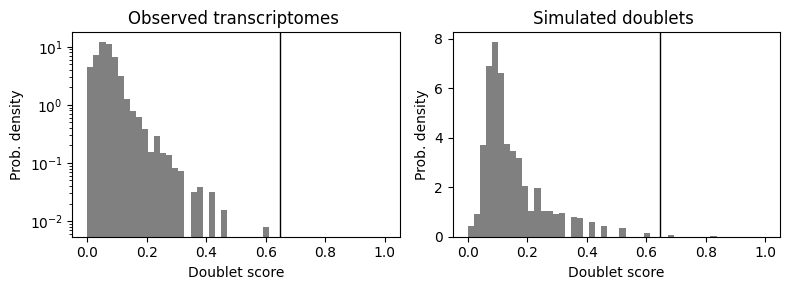

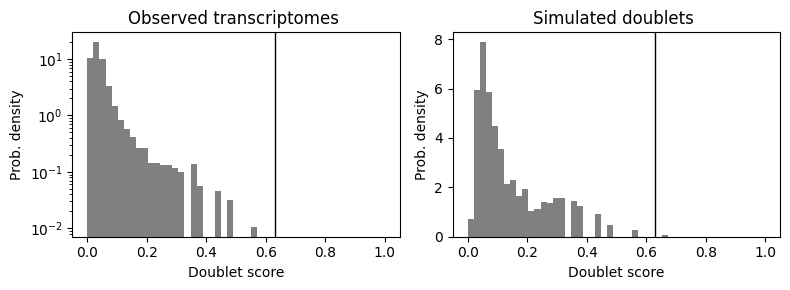

In [9]:
for ad in adata_dict.values():

    sc.pl.scrublet_score_distribution(ad)

In [13]:
doublet_threshold = [0.25,0.4,0.20,0.20,0.30,0.4,0.4,0.4,0.3,0.4,0.2,0.2,0.4,0.4,0.4,0.25,0.4,0.4,0.4,0.25,0.2,0.2,0.3,0.2,0.35,0.25,0.25,0.2,0.2,0.35,0.35]

In [14]:
len(doublet_threshold) == len(adata_dict.keys())

True

In [20]:
adata_dict['GSM4909281']

AnnData object with n_obs × n_vars = 3436 × 15927
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'
    uns: 'scrublet'

In [21]:
adata_dict['GSM4909281'].obs[['doublet_score','predicted_doublet']]

,doublet_score,predicted_doublet
AAACCTGCAAGCGTAG-1,0.037298,False
AAACCTGCAATAGAGT-1,0.035665,False
AAACCTGCAATTGCTG-1,0.051635,False
AAACCTGCACTCAGGC-1,0.054222,False
AAACCTGCAGTGACAG-1,0.123558,False
...,...,...
TTTGTCAAGTTAGGTA-1,0.063116,False
TTTGTCACACGTGAGA-1,0.039017,False
TTTGTCACATCGGAAG-1,0.066530,False
TTTGTCATCCCGACTT-1,0.074197,False


In [17]:
with open("after_scrublet_adata_dict.pkl", "wb") as f:
    pickle.dump(adata_dict, f)

# Integrate into a single object

In [ ]:
import anndata as ad

In [ ]:
adata_list = list(adata_dict.values())
keys = list(adata_dict.keys())

In [ ]:
adata = ad.concat(
            adata_list, 
            join='outer', # includes all genes (obs)
            fill_value=0, # if the gene do not appear it is filled with 0
            label='batch', 
            merge='unique',# make obs / vars unique to prevent conflicss
            keys = keys, 
            index_unique='-')

# Data Normalization

In [ ]:
adata.layers['counts'] = adata.X # save unnormalized (but gene filtered) counts in counts layer
sc.pp.normalize_total(adata, target_sum = 10000)
sc.pp.log1p(adata)   

# HVG selection

In [ ]:
sc.highly_variable_genes(adata, n_top_genes = 3000)

In [ ]:
adata.write_h5ad('')